In [1]:
import pickle
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from typing import List, Set, Tuple
from graph import Graph


In [2]:
# Load the training_graphs
with open('data/graphs.dat', 'rb') as file:
    graphs: List[Graph] = pickle.load(file)

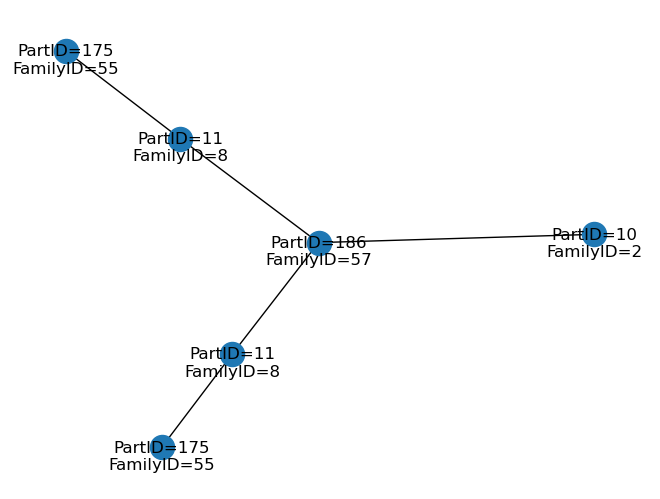

In [3]:
graphs[2].draw()

In [4]:
# Calculate some relevant statistics

max_part_id = -1 # 2270
max_family_id = -1 # 587

parts_set = set()

for graph in graphs:
    parts = graph.get_parts()
    for part in parts:
        parts_set.add(int(part.get_part_id()))
        max_part_id = max(int(part.get_part_id()), max_part_id)
        max_familiy_id = max(int(part.get_part_id()), max_family_id)


print(max_part_id)
print(max_familiy_id)

2270
587


In [5]:
## Make it dense (create mapping)
print(len(parts_set))
parts = list(parts_set)
parts.sort()

size = len(parts) + 1

parts_map = dict()

for new_id, old_id in enumerate(parts):
    parts_map[old_id] = new_id

print(parts_map)

1081
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 25: 24, 27: 25, 28: 26, 29: 27, 30: 28, 31: 29, 33: 30, 35: 31, 36: 32, 37: 33, 38: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 45: 40, 46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 52: 46, 53: 47, 54: 48, 55: 49, 56: 50, 57: 51, 58: 52, 60: 53, 61: 54, 62: 55, 63: 56, 64: 57, 65: 58, 66: 59, 67: 60, 68: 61, 69: 62, 70: 63, 71: 64, 72: 65, 73: 66, 74: 67, 75: 68, 76: 69, 77: 70, 78: 71, 79: 72, 80: 73, 81: 74, 82: 75, 83: 76, 84: 77, 85: 78, 86: 79, 87: 80, 88: 81, 90: 82, 92: 83, 93: 84, 95: 85, 96: 86, 97: 87, 98: 88, 99: 89, 100: 90, 101: 91, 102: 92, 103: 93, 104: 94, 105: 95, 106: 96, 107: 97, 108: 98, 109: 99, 111: 100, 112: 101, 113: 102, 114: 103, 115: 104, 116: 105, 117: 106, 118: 107, 119: 108, 120: 109, 121: 110, 122: 111, 123: 112, 125: 113, 127: 114, 128: 115, 129: 116, 130: 117, 131: 118, 134: 119, 136:

In [13]:
# Creat the features (one-hot encoded part_id, family_id)
features = []

for graph in graphs:
    feature = np.zeros(size)
    for part in graph.get_parts():
        old_part_id = int(part.get_part_id())
        new_part_id = parts_map[old_part_id]
        feature[new_part_id] += 1
    features.append(feature)

#torch.set_printoptions(profile="full")
#np.set_printoptions(threshold=sys.maxsize)

In [7]:
# Create the target (Adjacency Matrix)
matrices = []
for graph in graphs:
    matrix = graph.get_full_adjacency_matrix(size=size, part_mapping=parts_map)
    matrices.append(matrix)

In [8]:
## Create the Model

class FFNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(FFNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = x.view(-1, size, size)
        return x



model = FFNModel(size, size * size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
## Prepare the data for training

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, matrices, test_size=0.2, random_state=42)

## Is faster than using the built in list
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)
y_train_array = np.array(y_train)

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
## Traing process
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluation
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
print(f'Test Loss: {test_loss/len(test_loader)}')